In [433]:
import pandas as ps
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk

nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from IPython.display import display_html
from itertools import chain,cycle
from bs4 import BeautifulSoup

stop_words = set(stopwords.words('english'))

import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap
import geopandas as gpd
import branca.colormap


# Get data from source
#LISTINGS_URL = "http://data.insideairbnb.com/sweden/stockholms-l%C3%A4n/stockholm/2021-02-25/data/listings.csv.gz"
#CALENDAR_URL = "http://data.insideairbnb.com/sweden/stockholms-l%C3%A4n/stockholm/2021-02-25/data/calendar.csv.gz"
#REVIEWS_URL = http://data.insideairbnb.com/sweden/stockholms-l%C3%A4n/stockholm/2021-02-25/data/reviews.csv.gz"

#df1 = ps.read_csv(LISTINGS_URL, compression='gzip')
#df2 = ps.read_csv(CALENDAR_URL, compression='gzip')
#df3 = ps.read_csv(REVIEWS_URL, compression='gzip')

# Getting data locally in development is faster
LISTINGS = 'listings.csv'
CALENDAR = 'calendar.csv'
REVIEWS = 'reviews.csv'

df1 = ps.read_csv(LISTINGS)
df2 = ps.read_csv(REVIEWS)
df3 = ps.read_csv(CALENDAR)

# Show all columns
ps.set_option('display.max_columns', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vilhelmi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [434]:
# Example of columns and values
print(df2.columns.tolist())
print(df3.columns.tolist())
print(df1.shape)
df1.head()

['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments']
['listing_id', 'date', 'available', 'price', 'adjusted_price', 'minimum_nights', 'maximum_nights']
(2796, 74)


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,20083,https://www.airbnb.com/rooms/20083,20210225053501,2021-02-25,Unique in Södermalm SOFO Stockholm,Enjoy a stay in one of the most idyllic and co...,NaN,https://a0.muscache.com/pictures/102900/423071...,75962,https://www.airbnb.com/users/show/75962,Lovisa,2010-01-31,"Stockholm, Stockholm, Sweden","I'm 31, I work in the oldest now operating auc...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/75962/profile...,https://a0.muscache.com/im/users/75962/profile...,NaN,1,1,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,NaN,Södermalms,NaN,59.30643,18.08785,Entire apartment,Entire home/apt,3,NaN,1 bath,1.0,1.0,"[""Smoke alarm"", ""Dryer"", ""Hair dryer"", ""Iron"",...",$995.00,4,28,4.0,4.0,28.0,28.0,4.0,28.0,NaN,t,29,59,89,364,2021-02-25,12,0,0,2010-03-28,2014-09-01,100.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,f,1,1,0,0,0.09
1,164448,https://www.airbnb.com/rooms/164448,20210225053501,2021-02-25,Double room in central Stockholm with Wi-Fi,I am renting out a nice double room on the top...,NaN,https://a0.muscache.com/pictures/1101571/13429...,784312,https://www.airbnb.com/users/show/784312,Li,2011-07-06,"Stockholm, Stockholm, Sweden","I am a recently retired lady, who has two room...",within a day,100%,100%,t,https://a0.muscache.com/im/users/784312/profil...,https://a0.muscache.com/im/users/784312/profil...,Södermalm,2,2,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,NaN,Södermalms,NaN,59.31268,18.06258,Private room in apartment,Private room,2,NaN,1 shared bath,1.0,2.0,"[""Bed linens"", ""Washer"", ""Smoke alarm"", ""Dedic...",$643.00,3,300,3.0,3.0,300.0,300.0,3.0,300.0,NaN,t,29,59,89,179,2021-02-25,313,0,0,2011-07-30,2020-01-29,97.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,t,2,0,2,0,2.68
2,170651,https://www.airbnb.com/rooms/170651,20210225053501,2021-02-25,Petit Charm Rooftop next to heaven,<b>The space</b><br />Welcome to this beautifu...,NaN,https://a0.muscache.com/pictures/77469446/c3be...,814021,https://www.airbnb.com/users/show/814021,Marie,2011-07-13,"Stockholm, Stockholm, Sweden",Im a happy person living with my daughter Emma...,within a day,100%,0%,f,https://a0.muscache.com/im/pictures/user/137c6...,https://a0.muscache.com/im/pictures/user/137c6...,Södermalm,1,1,"['email', 'phone', 'reviews', 'offline_governm...",t,t,NaN,Södermalms,NaN,59.31568,18.03138,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,2.0,"[""Dryer"", ""Hair dryer"", ""Essentials"", ""Hot wat...","$1,387.00",4,30,4.0,4.0,30.0,30.0,4.0,30.0,NaN,t,18,40,62,297,2021-02-25,34,1,0,2011-08-14,2020-03-09,93.0,10.0,9.0,10.0,10.0,10.0,9.0,NaN,f,1,1,0,0,0.29
3,206221,https://www.airbnb.com/rooms/206221,20210225053501,2021-02-27,Doubleroom at Södermalm &trendySofo,<b>

In [435]:
# Helper functions
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)
    
def convert_currency(val):
    """
    Convert the string number value to a float
     - Remove $
     - Remove commas
     - Convert to float type
    """
    new_val = val.replace(',','').replace('$', '')
    return float(new_val)

def preprocess_text(text):
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove unicode
    #text = (text.encode('ascii', 'ignore')).decode('utf-8')
    # Remove stopwords
    text_tokens = word_tokenize(text)
    words = set(nltk.corpus.words.words())
    filtered_words = [w for w in text_tokens if not w in stop_words]
    filtered_words = [w for w in filtered_words if w.lower() in words or not w.isalpha()]
    
    return " ".join(filtered_words)

In [436]:
# Data wrangling of listings data

columns = [
    'id',
    'name',
    'description',
    'host_name',
    'host_since',
    #'host_location',
    'host_neighbourhood',
    'neighbourhood',
    'neighbourhood_cleansed',
    'latitude',
    'longitude',
    #'host_about',
    #'host_response_time',
    #'host_response_rate',
    'host_is_superhost',
    'host_listings_count',
    'host_has_profile_pic',
    'host_identity_verified',
    'property_type',
    'room_type',
    'accommodates',
    'price',
    'number_of_reviews',
    'review_scores_rating',
    'review_scores_cleanliness',
    'reviews_per_month'
    
]

df1 = df1[columns]

# Replace id as the index
print(df1['id'].is_unique)
df1.set_index('id', inplace=True)
df1.head()

True


,name,description,host_name,host_since,host_neighbourhood,neighbourhood,neighbourhood_cleansed,latitude,longitude,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,property_type,room_type,accommodates,price,number_of_reviews,review_scores_rating,review_scores_cleanliness,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
20083,Unique in Södermalm SOFO Stockholm,Enjoy a stay in one of the most idyllic and co...,Lovisa,2010-01-31,NaN,NaN,Södermalms,59.30643,18.08785,f,1,t,t,Entire apartment,Entire home/apt,3,$995.00,12,100.0,10.0,0.09
164448,Double room in central Stockholm with Wi-Fi,I am renting out a nice double room on the top...,Li,2011-07-06,Södermalm,NaN,Södermalms,59.31268,18.06258,t,2,t,t,Private room in apartment,Private room,2,$643.00,313,97.0,10.0,2.68
170651,Petit Charm Rooftop next to heaven,<b>The space</b><br />Welcome to this beautifu...,Marie,2011-07-13,Södermalm,NaN,Södermalms,59.31568,18.03138,f,1,t,t,Entire apartment,Entire home/apt,4,"$1,387.00",34,93.0,9.0,0.29
206221,Doubleroom at Södermalm &trendySofo,<b>The space</b><br />The region is situated a...,Elisabeth,2011-08-26,NaN,NaN,Södermalms,59.31226,18.07942,f,1,t,f,Shared room in apartment,Shared room,2,$669.00,79,98.0,10.0,0.70
220851,One room in appartement,Welcome!<br /><br /><b>The space</b><br />Welc...,Fredric,2011-02-27,Kungsholmen,"Stockholm, Stockholm County, Sweden",Kungsholmens,59.33376,18.03816,f,2,t,t,Private room in apartment,Private room,1,$600.00,48,93.0,9.0,0.42


In [437]:
# Need to convert some boolean values
d = {'t': True, 'f': False}
df1['host_is_superhost'] = df1['host_is_superhost'].map(d)
df1['host_has_profile_pic'] = df1['host_has_profile_pic'].map(d)
df1['host_identity_verified'] = df1['host_identity_verified'].map(d)
df1.head()

,name,description,host_name,host_since,host_neighbourhood,neighbourhood,neighbourhood_cleansed,latitude,longitude,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,property_type,room_type,accommodates,price,number_of_reviews,review_scores_rating,review_scores_cleanliness,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
20083,Unique in Södermalm SOFO Stockholm,Enjoy a stay in one of the most idyllic and co...,Lovisa,2010-01-31,NaN,NaN,Södermalms,59.30643,18.08785,False,1,True,True,Entire apartment,Entire home/apt,3,$995.00,12,100.0,10.0,0.09
164448,Double room in central Stockholm with Wi-Fi,I am renting out a nice double room on the top...,Li,2011-07-06,Södermalm,NaN,Södermalms,59.31268,18.06258,True,2,True,True,Private room in apartment,Private room,2,$643.00,313,97.0,10.0,2.68
170651,Petit Charm Rooftop next to heaven,<b>The space</b><br />Welcome to this beautifu...,Marie,2011-07-13,Södermalm,NaN,Södermalms,59.31568,18.03138,False,1,True,True,Entire apartment,Entire home/apt,4,"$1,387.00",34,93.0,9.0,0.29
206221,Doubleroom at Södermalm &trendySofo,<b>The space</b><br />The region is situated a...,Elisabeth,2011-08-26,NaN,NaN,Södermalms,59.31226,18.07942,False,1,True,False,Shared room in apartment,Shared room,2,$669.00,79,98.0,10.0,0.70
220851,One room in appartement,Welcome!<br /><br /><b>The space</b><br />Welc...,Fredric,2011-02-27,Kungsholmen,"Stockholm, Stockholm County, Sweden",Kungsholmens,59.33376,18.03816,False,2,True,True,Private room in apartment,Private room,1,$600.00,48,93.0,9.0,0.42


In [438]:
# Check for invalid data types
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2796 entries, 20083 to 48314089
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       2794 non-null   object 
 1   description                2688 non-null   object 
 2   host_name                  2796 non-null   object 
 3   host_since                 2796 non-null   object 
 4   host_neighbourhood         1841 non-null   object 
 5   neighbourhood              1509 non-null   object 
 6   neighbourhood_cleansed     2796 non-null   object 
 7   latitude                   2796 non-null   float64
 8   longitude                  2796 non-null   float64
 9   host_is_superhost          2796 non-null   bool   
 10  host_listings_count        2796 non-null   int64  
 11  host_has_profile_pic       2796 non-null   bool   
 12  host_identity_verified     2796 non-null   bool   
 13  property_type              2796 non-null

In [439]:
# Convert to best possible types
df1 = df1.convert_dtypes()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2796 entries, 20083 to 48314089
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       2794 non-null   string 
 1   description                2688 non-null   string 
 2   host_name                  2796 non-null   string 
 3   host_since                 2796 non-null   string 
 4   host_neighbourhood         1841 non-null   string 
 5   neighbourhood              1509 non-null   string 
 6   neighbourhood_cleansed     2796 non-null   string 
 7   latitude                   2796 non-null   Float64
 8   longitude                  2796 non-null   Float64
 9   host_is_superhost          2796 non-null   boolean
 10  host_listings_count        2796 non-null   Int64  
 11  host_has_profile_pic       2796 non-null   boolean
 12  host_identity_verified     2796 non-null   boolean
 13  property_type              2796 non-null

In [440]:
# Fix date types
df1['host_since'] = df1['host_since'].astype('datetime64')
df1['host_since'].head()

id
20083    2010-01-31
164448   2011-07-06
170651   2011-07-13
206221   2011-08-26
220851   2011-02-27
Name: host_since, dtype: datetime64[ns]

In [441]:
# Price contains unwanted characters and has wrong type
df1['price'] = df1['price'].apply(convert_currency)
df1['price'].head()

id
20083      995.0
164448     643.0
170651    1387.0
206221     669.0
220851     600.0
Name: price, dtype: float64

In [442]:
# The results so far
df1.info()
df1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2796 entries, 20083 to 48314089
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   name                       2794 non-null   string        
 1   description                2688 non-null   string        
 2   host_name                  2796 non-null   string        
 3   host_since                 2796 non-null   datetime64[ns]
 4   host_neighbourhood         1841 non-null   string        
 5   neighbourhood              1509 non-null   string        
 6   neighbourhood_cleansed     2796 non-null   string        
 7   latitude                   2796 non-null   Float64       
 8   longitude                  2796 non-null   Float64       
 9   host_is_superhost          2796 non-null   boolean       
 10  host_listings_count        2796 non-null   Int64         
 11  host_has_profile_pic       2796 non-null   boolean       
 12

,name,description,host_name,host_since,host_neighbourhood,neighbourhood,neighbourhood_cleansed,latitude,longitude,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,property_type,room_type,accommodates,price,number_of_reviews,review_scores_rating,review_scores_cleanliness,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
20083,Unique in Södermalm SOFO Stockholm,Enjoy a stay in one of the most idyllic and co...,Lovisa,2010-01-31,<NA>,<NA>,Södermalms,59.30643,18.08785,False,1,True,True,Entire apartment,Entire home/apt,3,995.0,12,100,10,0.09
164448,Double room in central Stockholm with Wi-Fi,I am renting out a nice double room on the top...,Li,2011-07-06,Södermalm,<NA>,Södermalms,59.31268,18.06258,True,2,True,True,Private room in apartment,Private room,2,643.0,313,97,10,2.68
170651,Petit Charm Rooftop next to heaven,<b>The space</b><br />Welcome to this beautifu...,Marie,2011-07-13,Södermalm,<NA>,Södermalms,59.31568,18.03138,False,1,True,True,Entire apartment,Entire home/apt,4,1387.0,34,93,9,0.29
206221,Doubleroom at Södermalm &trendySofo,<b>The space</b><br />The region is situated a...,Elisabeth,2011-08-26,<NA>,<NA>,Södermalms,59.31226,18.07942,False,1,True,False,Shared room in apartment,Shared room,2,669.0,79,98,10,0.7
220851,One room in appartement,Welcome!<br /><br /><b>The space</b><br />Welc...,Fredric,2011-02-27,Kungsholmen,"Stockholm, Stockholm County, Sweden",Kungsholmens,59.33376,18.03816,False,2,True,True,Private room in apartment,Private room,1,600.0,48,93,9,0.42


In [443]:
# Property_type and room_type could be categories
print(df1['property_type'].unique())
print(df1['room_type'].unique())

<StringArray>
[                  'Entire apartment',          'Private room in apartment',
           'Shared room in apartment',              'Private room in house',
                  'Entire guesthouse',          'Private room in townhouse',
                       'Entire house',                        'Entire loft',
               'Private room in loft',              'Private room in villa',
                   'Entire townhouse', 'Private room in serviced apartment',
                 'Entire condominium',                       'Entire villa',
  'Private room in bed and breakfast',          'Entire serviced apartment',
        'Private room in condominium',                 'Entire guest suite',
                       'Entire cabin',              'Shared room in hostel',
        'Private room in guest suite',                      'Room in hotel',
                          'Camper/RV',               'Shared room in house',
                          'Farm stay',                     'Ro

In [444]:
df1['property_type'] = df1['property_type'].astype('category')
df1['room_type'] = df1['room_type'].astype('category')
df1.info()
df1['property_type'].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2796 entries, 20083 to 48314089
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   name                       2794 non-null   string        
 1   description                2688 non-null   string        
 2   host_name                  2796 non-null   string        
 3   host_since                 2796 non-null   datetime64[ns]
 4   host_neighbourhood         1841 non-null   string        
 5   neighbourhood              1509 non-null   string        
 6   neighbourhood_cleansed     2796 non-null   string        
 7   latitude                   2796 non-null   Float64       
 8   longitude                  2796 non-null   Float64       
 9   host_is_superhost          2796 non-null   boolean       
 10  host_listings_count        2796 non-null   Int64         
 11  host_has_profile_pic       2796 non-null   boolean       
 12

id
20083              Entire apartment
164448    Private room in apartment
170651             Entire apartment
206221     Shared room in apartment
220851    Private room in apartment
Name: property_type, dtype: category
Categories (43, object): ['Boat', 'Camper/RV', 'Casa particular', 'Entire apartment', ..., 'Shared room in house', 'Shared room in serviced apartment', 'Shared room in tiny house', 'Tiny house']

In [445]:
# Let's remove empty values
df1 = df1.dropna(axis=0)
df1.info()
df1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 971 entries, 220851 to 47741278
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   name                       971 non-null    string        
 1   description                971 non-null    string        
 2   host_name                  971 non-null    string        
 3   host_since                 971 non-null    datetime64[ns]
 4   host_neighbourhood         971 non-null    string        
 5   neighbourhood              971 non-null    string        
 6   neighbourhood_cleansed     971 non-null    string        
 7   latitude                   971 non-null    Float64       
 8   longitude                  971 non-null    Float64       
 9   host_is_superhost          971 non-null    boolean       
 10  host_listings_count        971 non-null    Int64         
 11  host_has_profile_pic       971 non-null    boolean       
 12

,name,description,host_name,host_since,host_neighbourhood,neighbourhood,neighbourhood_cleansed,latitude,longitude,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,property_type,room_type,accommodates,price,number_of_reviews,review_scores_rating,review_scores_cleanliness,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
220851,One room in appartement,Welcome!<br /><br /><b>The space</b><br />Welc...,Fredric,2011-02-27,Kungsholmen,"Stockholm, Stockholm County, Sweden",Kungsholmens,59.33376,18.03816,False,2,True,True,Private room in apartment,Private room,1,600.0,48,93,9,0.42
238411,Cozy apartment in central Stockholm,"<b>The space</b><br />This is a cozy, fully eq...",Mia,2011-10-05,Norrmalm,"Stockholm, Stockholm County, Sweden",Norrmalms,59.3389,18.04962,False,1,True,True,Entire apartment,Entire home/apt,2,995.0,112,96,9,0.99
278311,Entire apt (some weeks this summer),When we will be away in the summer it's possib...,Linnéa,2011-11-29,Farsta,"Farsta, Stockholms län, Sweden",Farsta,59.24534,18.08729,False,1,True,True,Entire apartment,Entire home/apt,6,360.0,53,93,9,0.47
283446,Comfort Stay @ Kista - Super Value!,"Independent private room, 24x7 broadband WiFi...",Vidhatri,2011-12-06,Rinkeby-Kista,"Stockholm, Stockholm County, Sweden",Rinkeby-Tensta,59.41533,17.91465,False,1,True,True,Private room in apartment,Private room,2,360.0,104,97,10,0.99
299154,Cosy apartment central at Sodermalm,Very centrally located small apartment at Slus...,Daniel,2011-12-28,Södermalm,"Stockholm, Stockholm County, Sweden",Södermalms,59.31846,18.07042,True,1,True,True,Entire apartment,Entire home/apt,4,1056.0,527,92,9,5.62


In [446]:
# Description column has HTML tags and unwanted characters
#print(df1['description'].values[2])
#print('\n')

#df1['description'] = df1['description'].str.replace('<[^<]+?>', '', regex=True)

#df1['description'] = df1['description'].apply(preprocess_text)

#df1['description'] = df1['description'].str.replace('</b>', '. ')
#df1['description'] = df1['description'].str.replace('<br />', '')
#df1['description'] = df1['description'].str.replace('<b>', '')
#df1['description'] = df1['description'].str.replace('<br /', '')

#print(df1['description'].values[2])

Minimumn price: 99.0 maximum price: 90000.0 



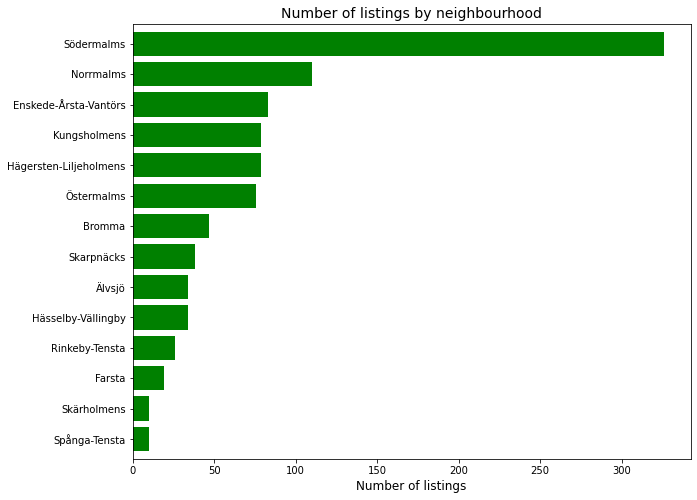

In [447]:
price_data = df1[['price', 'neighbourhood_cleansed', 'latitude', 'longitude']]
min_price = price_data['price'].min()
max_price = price_data['price'].max()

print("Minimumn price:", min_price, "maximum price:", max_price, "\n")
#print(price_data[0:10])#  Mean prices in each neighbourhood

mean_prices = price_data.groupby('neighbourhood_cleansed')['price'].mean().astype('int64')

# Now let's plot mean prices and neighbourhood listings together

#print(mean_prices, "\n")

#df.plot(x="X", y=["A", "B", "C"], kind="bar")

listings = df1['neighbourhood_cleansed'].value_counts().sort_values(ascending=True).rename("listings_amount")
listings.plot.barh(figsize=(10,8), color = 'green', width= 0.8)
plt.title('Number of listings by neighbourhood', fontsize=14)
plt.xlabel('Number of listings', fontsize = 12)
plt.show()

<ipython-input-448-d128510548fc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data['PriceRange'] = ps.cut(price_data['price'], bins, labels=names)


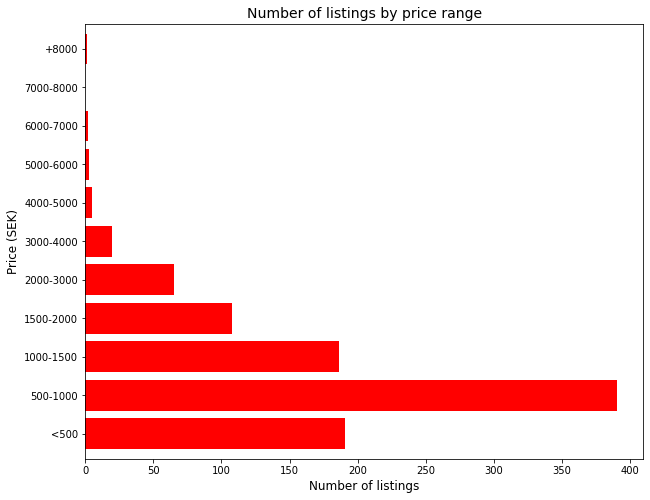

In [448]:
# Good to remember that prices are in SEK

bins = [0, 500, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 7000, 8000, np.inf]
names = ['<500', '500-1000','1000-1500', '1500-2000', '2000-3000', '3000-4000', '4000-5000', '5000-6000', '6000-7000', '7000-8000', '+8000']

price_data['PriceRange'] = ps.cut(price_data['price'], bins, labels=names)
prices = price_data['PriceRange'].value_counts()
prices = prices.reindex(names)

prices.plot.barh(figsize=(10,8), color ='r', width= 0.8)
plt.title('Number of listings by price range', fontsize=14)
plt.xlabel('Number of listings', fontsize = 12)
plt.ylabel('Price (SEK)', fontsize = 12)
plt.show()

Minimumn price: 99.0 maximum price: 90000.0 



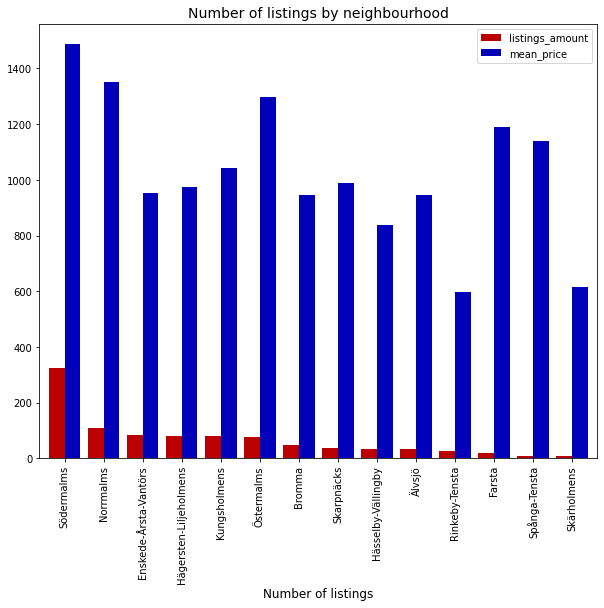

In [449]:
price_data = df1[['price', 'neighbourhood_cleansed', 'latitude', 'longitude']]

# What are the maximum and minimum prices?
min_price = price_data['price'].min()
max_price = price_data['price'].max()

print("Minimumn price:", min_price, "maximum price:", max_price, "\n")

# Calculate mean prices in each neighbourhood
mean_prices = price_data.groupby('neighbourhood_cleansed')['price'].mean().astype('int64')

# Now let's plot mean prices and neighbourhood listings together

frequencies = df1['neighbourhood_cleansed'].value_counts().rename("listings_amount")
test = ps.DataFrame(frequencies, columns = ['listings_amount'])
test['mean_price'] = mean_prices
test.plot.bar(figsize=(10,8), y=['listings_amount', 'mean_price'], color = ['#BB0000', '#0000BB'], width= 0.8)

plt.title('Number of listings by neighbourhood', fontsize=14)
plt.xlabel('Number of listings', fontsize = 12)
plt.show()

In [450]:
# https://towardsdatascience.com/airbnb-part-b-python-interactive-map-natural-language-processing-48d472f14da3

STOCKHOLM_COORDINATES = [59.329, 18.069]
TILEs = ["http://tile.stamen.com/terrain/{z}/{x}/{y}.jpg"]

latitudes = df1['latitude'].tolist()
longitudes=df1['longitude'].tolist()
locations = list(zip(latitudes, longitudes))

sw = df1[['latitude', 'longitude']].min().values.tolist()
ne = df1[['latitude', 'longitude']].max().values.tolist()

bounds = [sw, ne]

# Create map
map1 = folium.Map(location=STOCKHOLM_COORDINATES, zoom_start=12.5, maxBounds=bounds, min_zoom=11)

# Add fastmarkers
FastMarkerCluster(data=locations, name='Listing markers').add_to(map1)

# Add heat map
heat_df = df1[['latitude', 'longitude']]
heat_df = heat_df.dropna(axis=0, subset=['latitude','longitude'])
heat_data = [[row['latitude'],row['longitude']] for index, row in heat_df.iterrows()]
HeatMap(heat_data, name='Listings heat map').add_to(map1)

# Add legend
gradient = []
colormap = branca.colormap.linear.YlOrRd_09.scale(0, 100)
colormap = colormap.to_step(index=[0, 10, 25, 50, 75, 100])
colormap.caption = 'Listings'
colormap.add_to(map1)

# Add toggle control
folium.map.LayerControl('topleft', collapsed= False).add_to(map1)

# Display map
map1

In [451]:
#https://www.kaggle.com/daveianhickey/how-to-folium-for-maps-heatmaps-time-data
    
STOCKHOLM_COORDINATES = [59.329, 18.069]

bounds =[
    [59.6768, 19.0421],
    [59.0596, 16.8860]
]

map2 = folium.Map(location=STOCKHOLM_COORDINATES, zoom_start=12.5, maxBounds=bounds)
#FastMarkerCluster(data=locations).add_to(map1)
#map2

colormap = branca.colormap.linear.YlOrRd_09.scale(0, 400)
colormap = colormap.to_step(index=[0, 50, 100, 200, 300, 400])
colormap.caption = 'Listings'
colormap.add_to(map2)

heat_df = df1[['latitude', 'longitude']]
heat_df = heat_df.dropna(axis=0, subset=['latitude','longitude'])
heat_data = [[row['latitude'],row['longitude']] for index, row in heat_df.iterrows()]

HeatMap(heat_data).add_to(map2)

map2